# Homework 5: Lorenz attractor

### Objectives

This homework is intended to get you more comfortable with the syntax involved in solving ordinary differential equations. We will focus in particular on a convenient way to pass parameters to `scipy.integrate.solve_ivp`, so-called "lambda functions".

## Initialization

As always you should add initialization to the top of your notebook.

In [4]:
### BEGIN SOLUTION
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integ
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
### END SOLUTION

## Problem 1

Here we are considering the function

$$ f(x) = \mathrm{e}^{-x/3}, $$

which has derivative

$$ f'(x) = -\frac{1}{3} \mathrm{e}^{-x/3}. $$

We will evaluate the derivative at $x=0.7$ using center differencing. For convenience let us define our own function for taking center differencing. We will have this function determine the exact representation for the step size, $\Delta x$. We also define our function and its derivative.

Step size  Fractional Error
1e-04   1.8365531317954265e-10
1e-05   5.136113756520899e-12
1e-06   7.69788677246197e-11
1e-07   4.194038449867321e-10


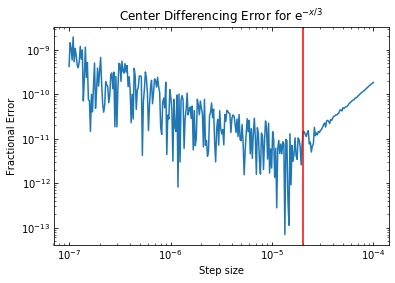

In [3]:
def center_difference (f, x, h10) :
    h = h10 + x
    h -= x
    return (f(x+h) - f(x-h))/(2.*h)

def f(x) :
    return np.exp(-x/3.)

def fderiv(x) :
    return -np.exp(-x/3.) / 3.

harr = np.array([1e-4, 1e-5, 1e-6, 1e-7])
x = 0.7
dfdx_true = fderiv(x)
dfdx_center = center_difference(f, x, harr)
print('Step size  Fractional Error')
for j in range(len(harr)) :
    print(f'{harr[j]:.0e}   {np.abs(1-dfdx_center[j]/dfdx_true)}')

hgrid = np.logspace(-7, -4, 300)
plt.loglog(hgrid, np.abs(1 - center_difference(f, x, hgrid)/dfdx_true))
# This line comes from part (iii)
plt.axvline(2e-5, color='r')
plt.xlabel('Step size')
plt.ylabel('Fractional Error')
plt.title(r'Center Differencing Error for $\mathrm{e}^{-x/3}$');

## Lambda functions: Extra arguments

As we saw above, while odeint supports the `args=()` we have seen in many places, `solve_ivp` does not! What do we do when the function that defines our system of first order differential equation requires extra arguments?

There are a number of approaches we can consider (and if you search online you will find some interesting ones). One would be to take the function we define that needs extra arguments, copy it, and hard code in values for the extra arguments, for each set of extra arguments required. However, this is not an idea I recommend. Another approach we can use and is known as lambda functions.

If you are familiar with functional programming then lambda functions are something you know. Though Python is a procedural language (like C, FORTRAN, Java, etc.) there are many things that can be done using the functional programming paradigm. Unfortunately we will not explore those here, we will focus on the one thing we need.

A simple way to understand them is that a lambda function is a simple function without a name that executes a single line of code and returns a value. We can assign a lambda function to a variable, pass it to another function, etc. Its basic structure is

```
lambda arg1,arg2 : do something with arg1 and arg2
```

There can be an arbitrary number of arguments and the "do something" is a single statement/expression that uses the arguments and produces a value. Notice that return is not needed and cannot be included.

As a simplistic example, suppose I wanted to define a cosine function that accepted angles in degrees instead of radians. I could define this as a lambda function as

```
cosdeg = lambda theta : np.cos(np.deg2rad(theta))
```

Now if I do something like

```
cosdeg(60)
```

it should return 0.5.

We will use this idea below in the conjuction with `solve_ivp` (and in the future for other purposes). Before proceeding let us verify that our simplistic example really does what we claim; run the following cell.

In [3]:
cosdeg = lambda theta : np.cos(np.deg2rad(theta))
cosdeg(60)

0.5000000000000001

In the in-class example, we looked at the following equation,
$$
\frac{dy}{dt} = \cos(y)
$$
and used the following code,

```
def A(t, y) :
    return np.cos(np.deg2rad(t))

sol = integ.solve_ivp( A, (0, 4*360),
                       np.array([0.]), vectorized=True, rtol=1.0e-6, atol=1.0e-6 )
```

We can instead use the following code, where we do not explicitly define a function `A`.

In [4]:
sol = integ.solve_ivp( lambda t,y: np.cos(np.deg2rad(t)), (0, 4*360),
                       np.array([0.]), vectorized=True, rtol=1.0e-6, atol=1.0e-6)

If we now want to solve an equation with an additional parameter $\Omega_0$, which is just a constant,

$$
\frac{dy}{dt} = \cos(\Omega_0 y)
$$

we can appropriately change the lambda function, or use the lambda function to pass a call. Below are two examples of this. You should read the code below, and make sure you understand how both of these methods work. The latter method is especially useful when solving multiple differential equations, and will be the recommend method for calling `solve_ivp`.

In [5]:
# First method: adjust the lambda function.
Omega_0 = 2.0*np.pi # This can be changed to any value of Omega.
sol = integ.solve_ivp( lambda t,y: np.cos(Omega_0*np.deg2rad(t)), (0, 4*360),
                       np.array([0.]), vectorized=True, rtol=1.0e-6, atol=1.0e-6)

In [6]:
# Second method: use a lambda function to make an appropriate call to the function A, which we re-define here.
def A(t, y, Omega) :
    """
    There is only one function we are integrating, which will be present in y[0].
    """
    dydt = np.zeros_like(y)
    dydt[0] = np.cos(Omega*np.deg2rad(t))
    return dydt

Omega_0 = 2.0*np.pi
sol = integ.solve_ivp( lambda t,y: A(t, y, Omega_0), (0, 4*360),
                       np.array([0.]), vectorized=True, rtol=1.0e-6, atol=1.0e-6 )

## The Lorenz system

The Lorenz attractor is a solution to the Lorenz system, a set of ordinary differential equations first studied by Edward Lorenz. It is well-known for generating butterfly-like chaotic patterns, the details of which are highly sensitive to initial conditions. The system of equations is given by

$$
\begin{align}
\frac{dx}{dt} & = \sigma (y-x) \\
\frac{dy}{dt} & = x(\rho-z) -y\\
\frac{dz}{dt} & = xy - \beta z
\end{align}
$$

for functions $x(t)$, $y(t)$, and $z(t)$, and constant parameters $\sigma$, $\rho$, and $\beta$. Integrate this system of equations for the following choices:
1. Use a lambda function to pass parameters $\sigma=10$, $\rho=28$, and $\beta=8/3$.
2. You can begin integration at any point, e.g. $(x, y, z)$ = $(1, 1, 1)$.
3. Integrate from $t=0$ to $t=50$.

Produce a plot of $x(t)$ vs $z(t)$. Feel free to explore the behavior of this system for different parameter choices, and plot different functions. If you are so inclined you may wish to produce a 3d plot. You may also wish to explore how sensitive your solution is to the `rtol` and `atol` parameters.

Text(0.5,0,'x(t)')

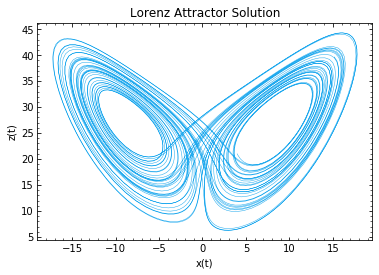

In [24]:
### BEGIN SOLUTION
def A(t, y, sigma, rho, beta) :
    """
    Choose order for y
    y[0] = x
    y[1] = y
    y[2] = z
    """
    dydt = np.zeros_like(y)
    dydt[0] = sigma*(y[1]-y[0])
    dydt[1] = y[0]*(rho-y[2])-y[1]
    dydt[2] = y[0]*y[1] - beta*y[2]
    return dydt

sigma = 10
rho = 28
beta = 8/3.
y0 = np.array([4., 5., 21.])
sol = integ.solve_ivp( lambda t,y: A(t, y, sigma, rho, beta), (0, 50),
                       y0, vectorized=True, rtol=1.0e-7, atol=1.0e-7 )

plt.plot(sol.y[0], sol.y[2], color='#22AAEE', linewidth=0.5)
plt.title("Lorenz Attractor Solution")
plt.ylabel("z(t)")
plt.xlabel("x(t)")
### END SOLUTION